In [1]:
import nbimporter
from lr_rfr_streampredictions import *

import os
import torch
from torch.optim import SGD
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math

pd.set_option('display.max_rows', 1000)

In [2]:
three_week_data = pd.read_csv('../csv_files/three_week_data.csv')

In [3]:
data = three_week_data
print(data.columns)
data

Index(['artist', 'title', 'unified_song_id', 'date', 'release_date',
       'this_day', 'this_week', 'days_since_release', 'day_of_week', 'rn',
       'end_of_week', 'popularity', 'day_0', 'day_1', 'day_2', 'day_3',
       'day_4', 'day_5', 'day_6', 'day_7', 'day_8', 'day_9', 'day_10',
       'day_11', 'day_12', 'day_13', 'day_14', 'day_15', 'day_16', 'day_17',
       'day_18', 'day_19', 'day_20', 'target', 'naive'],
      dtype='object')


,artist,title,unified_song_id,date,release_date,this_day,this_week,days_since_release,day_of_week,rn,...,day_13,day_14,day_15,day_16,day_17,day_18,day_19,day_20,target,naive
0,Gucci Mane,Gingerbread Man,91914,2021-12-22,2009-12-04,952,6066.0,4401,5,1,...,761.0,878.0,1022.0,948.0,935.0,907.0,877.0,768.0,5815,6039.0
1,Gucci Mane,Gingerbread Man,91914,2021-12-21,2009-12-04,850,6066.0,4400,4,1,...,878.0,1022.0,948.0,935.0,907.0,877.0,768.0,951.0,5815,6099.0
2,Gucci Mane,Gingerbread Man,91914,2021-07-31,2009-12-04,878,6363.0,4257,1,1,...,859.0,949.0,1061.0,1025.0,1036.0,984.0,899.0,811.0,6066,6424.0
3,Gucci Mane,Gingerbread Man,91914,2021-07-30,2009-12-04,1022,6363.0,4256,0,1,...,949.0,1061.0,1025.0,1036.0,984.0,899.0,811.0,979.0,6066,6362.0
4,Gucci Mane,Gingerbread Man,91914,2021-07-29,2009-12-04,948,6771.0,4255,6,1,...,1061.0,1025.0,1036.0,984.0,899.0,811.0,979.0,1054.0,6066,6587.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14567477,Tiesto & Lucas & Steve,ZENLESS,245214101,2024-07-06,2024-07-02,59943,61607.0,4,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,159339,NaN
14567478,Tiesto & Lucas & Steve,ZENLESS,245214101,2024-07-05,2024-07-02,74695,61607.0,3,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,159339,NaN
14567479,Tiesto & Lucas & Steve,ZENLESS,245214101,2024-07-04,2024-07-02,27206,NaN,2,6,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,159339,NaN
14567480,Tiesto & Lucas & Steve,ZENLESS,245214101,2024-07-03,2024-07-02,15107,NaN,1,5,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,195923,NaN


In [4]:
song = data[data['title'] == 'Listen To The Music']
song = song.sort_values('date', ascending=True)
song['date'] = pd.to_datetime(song['date'])
song = song[['date', 'this_day']]
song

,date,this_day
79394,2018-12-23,97815
79393,2018-12-24,95823
79392,2018-12-25,77739
79391,2018-12-26,133026
79390,2018-12-27,153306
...,...,...
77376,2024-07-02,520067
77375,2024-07-03,596273
77374,2024-07-04,840694
77373,2024-07-05,656542


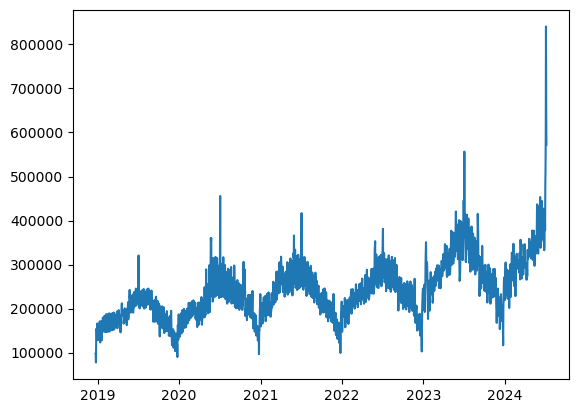

In [5]:
plt.plot(song['date'], song['this_day'])

In [6]:
days = ['day_' + str(i) for i in range(21)]
data = data[data['end_of_week'] == True]
data = data.rename(columns={'target': 'Next Full Week Streams'})
data = data[days + ['popularity', 'days_since_release', 'Next Full Week Streams']]
print(data.shape, '\n')
print(data.isnull().sum())

(2080205, 24) 

day_0                         0
day_1                      2144
day_2                      2921
day_3                      3336
day_4                      3594
day_5                      9422
day_6                      9459
day_7                     13961
day_8                     16073
day_9                     16831
day_10                    17233
day_11                    17502
day_12                    23391
day_13                    23432
day_14                    27729
day_15                    29818
day_16                    30551
day_17                    30945
day_18                    31193
day_19                    37042
day_20                    37087
popularity                    0
days_since_release            0
Next Full Week Streams        0
dtype: int64


In [7]:
(data == 0).sum()

day_0                        622
day_1                       1018
day_2                        930
day_3                        893
day_4                        940
day_5                        744
day_6                        595
day_7                        625
day_8                       1005
day_9                        904
day_10                       875
day_11                       912
day_12                       675
day_13                       583
day_14                       603
day_15                       991
day_16                       889
day_17                       855
day_18                       891
day_19                       682
day_20                       587
popularity                273683
days_since_release          2101
Next Full Week Streams         5
dtype: int64

In [8]:
data['days_since_release'] = data['days_since_release'] + 1
data

,day_0,day_1,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,...,day_14,day_15,day_16,day_17,day_18,day_19,day_20,popularity,days_since_release,Next Full Week Streams
4,948,935.0,907.0,877.0,768.0,951.0,989.0,1061.0,991.0,964.0,...,1025.0,1036.0,984.0,899.0,811.0,979.0,1054.0,23,4256,6066
11,1061,991.0,964.0,886.0,859.0,949.0,1061.0,1025.0,1036.0,984.0,...,989.0,931.0,987.0,848.0,900.0,995.0,1072.0,23,4249,6066
18,1025,1036.0,984.0,899.0,811.0,979.0,1054.0,989.0,931.0,987.0,...,1123.0,1002.0,980.0,927.0,852.0,926.0,1158.0,23,4242,6443
25,989,931.0,987.0,848.0,900.0,995.0,1072.0,1123.0,1002.0,980.0,...,1092.0,1011.0,980.0,941.0,830.0,1017.0,1150.0,23,4235,6363
32,1123,1002.0,980.0,927.0,852.0,926.0,1158.0,1092.0,1011.0,980.0,...,1020.0,1034.0,996.0,971.0,884.0,989.0,1045.0,23,4228,6771
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14567453,148913,207022.0,31378.0,528.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49,4,705091
14567459,36600,42021.0,42984.0,45940.0,48225.0,58884.0,67160.0,76456.0,42173.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60,9,174966
14567466,76456,42173.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60,2,214343
14567470,7434,10740.0,8655.0,8499.0,7107.0,8634.0,12435.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42,7,31397


In [9]:
train_valid, test = train_test_split(data, test_size = 0.20, random_state = 42)
train, valid = train_test_split(train_valid, test_size = 0.20, random_state = 42)

In [10]:
def log_apply(data, cols, prediction_col):
    copy = data.copy()
    for col in cols:
        copy[col] = np.log(copy[col])
        copy = copy.rename(columns={col: "log " + col})
    return copy[[c for c in copy if c != ('log ' + prediction_col)] + ['log ' + prediction_col]]

def pipeline(data):
    data = data.pipe(interpolate_vals, days)
    data = data.pipe(log_apply, days + ['days_since_release', 'Next Full Week Streams'], prediction_col='Next Full Week Streams')
    return data.drop('log Next Full Week Streams', axis=1), data['log Next Full Week Streams']

X_train, Y_train = pipeline(train)
X_valid, Y_valid = pipeline(valid)
X_test, Y_test = pipeline(test)

In [11]:
# Define a pipeline to search for the best combination of PCA truncation
# and classifier regularization.
pca = PCA()

# Define a Standard Scaler to normalize inputs
scaler = StandardScaler()

lr_pipe = Pipeline([
     ("scaler", scaler), 
     ("pca", pca), 
     ("regressor", Lasso())
])

# Parameters of pipelines can be set using '__' separated parameter names:
lr_params = {
    "pca__n_components": [5, 10, 15, 20, 23],
    "regressor": [Ridge(), Lasso()],
    "regressor__fit_intercept": [True, False],
    "regressor__alpha": [0.1, 0.2, 0.3]
}

search = GridSearchCV(lr_pipe, lr_params, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
search.fit(X_train, Y_train)

joblib.dump(search, '../models/three_week_preds.joblib')

['../models/four_week_preds.joblib']

In [13]:
saved_search = joblib.load('../models/three_week_preds.joblib')

In [19]:
print("Best parameter (CV score=%0.3e):" % saved_search.best_score_)
print(saved_search.best_params_)

model = saved_search.best_estimator_

Y_train_log_pred = model.predict(X_train)
Y_valid_log_pred = model.predict(X_valid)


Best parameter (CV score=-9.239e-02):
{'pca__n_components': 23, 'regressor': Ridge(alpha=0.1), 'regressor__alpha': 0.1, 'regressor__fit_intercept': True}


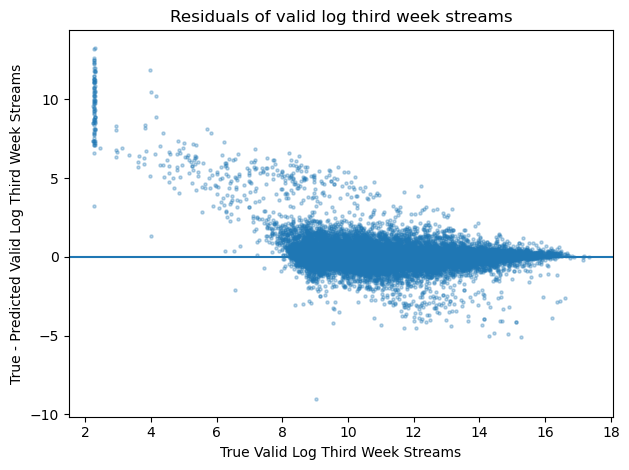

In [21]:
plt.scatter(Y_valid_log_pred, Y_valid - Y_valid_log_pred, alpha=0.3, s=5)
plt.axhline(0)
plt.xlabel("True Valid Log Third Week Streams")
plt.ylabel("True - Predicted Valid Log Third Week Streams")
plt.title("Residuals of valid log third week streams")
plt.tight_layout()

In [54]:
pd.options.display.float_format = '{:.2f}'.format

Y_test_log_pred = model.predict(X_test)
test_filled = interpolate_vals(test, days)

# Compute the number of weekly streams (with no overlap) across the lagged 21 day period
window1 = sum([test_filled[day] for day in days[:7]]) 
window2 = sum([test_filled[day] for day in days[7:14]]) 
window3 = sum([test_filled[day] for day in days[14:]]) 

# Average the three weeks
naive = (window1 + window3 + window




results = pd.DataFrame({
    'Y_test': np.e**Y_test,
    'Y_test_pred': np.e**Y_test_log_pred,
    'naive': naive
})

results

,Y_test,Y_test_pred,naive
3511817,31097.00,30607.98,11893.29
5321229,69438.00,65274.16,29967.00
7528330,1908230.00,1629558.09,835393.14
11082708,69643.00,65217.89,28912.57
14389939,196222.00,229491.58,111896.57
...,...,...,...
12325300,95737.00,110796.29,47595.00
12042900,73052.00,65750.34,28726.43
4724283,17348.00,15410.53,6870.43
9666303,66037.00,73586.49,32828.14


In [57]:
train_rmse = np.sqrt(mean_squared_error(np.e**Y_train, np.e**Y_train_log_pred))
test_rmse = np.sqrt(mean_squared_error(np.e**Y_test, np.e**Y_test_log_pred))
naive_rmse = np.sqrt(mean_squared_error(np.e**Y_test, naive))

print(f"Third Week Model Test Prediction: {test_rmse:0.3e}")
print(f"Third Week Naive Test Prediction: {naive_rmse:0.3e}")

Third Week Model Test Prediction: 1.615e+05
Third Week Naive Test Prediction: 3.358e+05
